# Importing Libraries

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#### Constants



In [163]:
# Data used for analysis
DATA='EURUSD'

# The events data prices before and after the event
HOURS_BEFORE=2
HOURS_AFTER=24

# price columns 
PRICE_COLUMNS = [str(num)+'h' for num in np.arange(-HOURS_BEFORE,HOURS_AFTER+1)]

# Predition columns
PREDICTED_FUTURE_PRICES = ['1h','3h','5h']

# PRICES TO DROP WHICH WE DONT NEED
PRICES_TO_DROP = PRICE_COLUMNS.copy()
for price in PREDICTED_FUTURE_PRICES:
    PRICES_TO_DROP.remove(price)
PRICES_TO_DROP.remove('0h')

# Events information columns
EVENT_COLUMNS = ['time','currency','description','impact','actual','deviation','consensus','previous','result']

# Since we already have extracted the meaning of this columns in the result we are discarding this columns
EVENT_COLUMNS_DROP = ['actual','deviation','consensus','previous']

# IMPACT COLORS to visualize
IMPACT_COLORS = {
    'low': '#F5C861',
    'medium': '#E4871B',
    'high': '#D25746',
    'none': 'black'
}

NULL_COLUMNS = []

FEATURES_INFO = {
    'time' : 'Time of event occuring',
    'currency': 'Currencies might be affected',
    'description' : 'Event Information',
    'impact': 'The impact is a basic indicator of the potential move a data release might trigger on currencies. Shall a bar be red and long, market observers expect this data to have great probability to move the Forex market. Shall this bar be yellow and short, the probability is viewed as low. In orange, we’re just in between.(Red: High,Orange: Medium,yellow: low, White: none)',
    'actual': 'Actual Value when event occured',
    'deviation': 'It measures the surprise caused when the Actual data differs from the Consensus. It can oscillate in an open scale usually between -7 and +7.',
    'consensus': 'It is a general agreement of experts on the outcome of the number.',
    'previous': 'It is the data in its last release (frequency of data release is variable: it can be last month, last trimester…).',
    'result' : 'Green: better than expected Red: worse than expected, Black : neutral'
}
for item in PRICE_COLUMNS:
    if item.startswith('-') or item.startswith('0h'):
        FEATURES_INFO[item] = 'Price before ' + item + ' of the event'
    else:
        FEATURES_INFO[item] = 'Price after ' + item + ' of the event'

In [164]:
EVENT_COLUMNS

['time',
 'currency',
 'description',
 'impact',
 'actual',
 'deviation',
 'consensus',
 'previous',
 'result']

In [165]:
PRICE_COLUMNS

['-2h',
 '-1h',
 '0h',
 '1h',
 '2h',
 '3h',
 '4h',
 '5h',
 '6h',
 '7h',
 '8h',
 '9h',
 '10h',
 '11h',
 '12h',
 '13h',
 '14h',
 '15h',
 '16h',
 '17h',
 '18h',
 '19h',
 '20h',
 '21h',
 '22h',
 '23h',
 '24h']

# Load Data

In [166]:
# Load the data according to the currency
frame = pd.read_csv('./data/events_'+DATA+'.csv',index_col=['time'],header=0)
# frame = pd.read_csv('./data/economic_events_'+DATA+'.csv',index_col=['time'],header=0)

# Convert the time string to datetime object
frame.index = pd.to_datetime(frame.index,format='%Y-%m-%d %H:%M:%S%z',utc=True)

# hex color actual colum contains the result : positive-green, negative - red, black-neutral
frame.rename(columns={'hex_color_actual':'result'},inplace=True)
type(frame.index)
frame.attrs['features'] = FEATURES_INFO
# Create MultiIndex
# frame['time'] = pd.to_datetime(frame['time'],format='%Y-%m-%d %H:%M:%S%z',utc=True)
# frame.set_index(['time','currency','description'])


# EDA

In [167]:
# Shape of the dataset
frame.shape

(29709, 35)

In [168]:
# Info about the dataset
frame.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29709 entries, 2013-01-02 09:13:00+00:00 to 2024-06-28 14:00:00+00:00
Data columns (total 35 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   currency     29709 non-null  object 
 1   description  29709 non-null  object 
 2   impact       29709 non-null  object 
 3   actual       29709 non-null  object 
 4   deviation    29709 non-null  object 
 5   consensus    29709 non-null  object 
 6   previous     29709 non-null  object 
 7   result       29709 non-null  object 
 8   -2h          29703 non-null  float64
 9   -1h          29704 non-null  float64
 10  0h           29698 non-null  float64
 11  1h           29664 non-null  float64
 12  2h           29604 non-null  float64
 13  3h           29578 non-null  float64
 14  4h           29567 non-null  float64
 15  5h           29545 non-null  float64
 16  6h           29183 non-null  float64
 17  7h           28877 non-null  float64
 18 

In [169]:
# Basic Stats
frame.describe()

,-2h,-1h,0h,1h,2h,3h,4h,5h,6h,7h,...,15h,16h,17h,18h,19h,20h,21h,22h,23h,24h
count,29703.000000,29704.000000,29698.000000,29664.000000,29604.000000,29578.000000,29567.000000,29545.000000,29183.000000,28877.000000,...,22686.000000,22400.000000,22384.000000,22384.000000,22379.000000,22377.000000,22383.000000,22386.000000,22384.000000,22373.000000
mean,1.153155,1.153137,1.153080,1.153028,1.152938,1.152854,1.152863,1.152857,1.153222,1.153185,...,1.154470,1.154505,1.154413,1.154396,1.154392,1.154327,1.154336,1.154309,1.154293,1.154276
std,0.090889,0.090908,0.090889,0.090874,0.090899,0.090867,0.090825,0.090827,0.090979,0.090896,...,0.091489,0.091783,0.091733,0.091722,0.091697,0.091690,0.091764,0.091803,0.091791,0.091771
min,0.955550,0.953880,0.954370,0.955580,0.954370,0.957390,0.956550,0.958450,0.959300,0.958110,...,0.953880,0.953880,0.953880,0.954370,0.954370,0.954370,0.953880,0.956550,0.955580,0.954370
25%,1.090870,1.090830,1.090830,1.091060,1.090910,1.090810,1.090870,1.090570,1.090750,1.091000,...,1.091000,1.090745,1.090690,1.090708,1.090780,1.090840,1.090685,1.090600,1.090558,1.090470
50%,1.127860,1.127810,1.127655,1.127410,1.127305,1.127230,1.127260,1.127230,1.127400,1.127430,...,1.128320,1.128240,1.128240,1.127945,1.127930,1.127900,1.127880,1.127775,1.127985,1.127930
75%,1.188330,1.188560,1.188522,1.188540,1.188382,1.188080,1.188240,1.188000,1.187990,1.187740,...,1.189625,1.189582,1.189710,1.189500,1.189680,1.189310,1.189550,1.189440,1.189310,1.189120
max,1.395620,1.396290,1.396290,1.396290,1.395430,1.395430,1.394920,1.394920,1.393340,1.393390,...,1.394510,1.395620,1.395210,1.396290,1.395120,1.395620,1.395210,1.396290,1.395210,1.396290


In [170]:
# Colums in dataset
frame.columns

Index(['currency', 'description', 'impact', 'actual', 'deviation', 'consensus',
       'previous', 'result', '-2h', '-1h', '0h', '1h', '2h', '3h', '4h', '5h',
       '6h', '7h', '8h', '9h', '10h', '11h', '12h', '13h', '14h', '15h', '16h',
       '17h', '18h', '19h', '20h', '21h', '22h', '23h', '24h'],
      dtype='object')

In [171]:
# Head of the dataset
frame.head(4)

,currency,description,impact,actual,deviation,consensus,previous,result,-2h,-1h,...,15h,16h,17h,18h,19h,20h,21h,22h,23h,24h
time,,,,,,,,,,,,,,,,,,,,,
2013-01-02 09:13:00+00:00,EUR,HCOB Manufacturing PMI(Dec),low,44.6,-0.48,45.1,45.3,red,1.32733,1.32809,...,1.31821,1.31703,1.31267,1.31387,1.31371,1.31382,1.31452,1.31339,1.31636,1.3147
2013-01-02 09:43:00+00:00,EUR,HCOB Manufacturing PMI(Dec),low,46.7,1.20,45.3,45.1,green,1.32733,1.32809,...,1.31821,1.31703,1.31267,1.31387,1.31371,1.31382,1.31452,1.31339,1.31636,1.3147
2013-01-02 09:48:00+00:00,EUR,HCOB Manufacturing PMI(Dec),low,44.6,0.00,44.6,44.6,black,1.32733,1.32809,...,1.31821,1.31703,1.31267,1.31387,1.31371,1.31382,1.31452,1.31339,1.31636,1.3147
2013-01-02 09:53:00+00:00,EUR,HCOB Manufacturing PMI(Dec),medium,46,-0.28,46.3,46.3,red,1.32733,1.32809,...,1.31821,1.31703,1.31267,1.31387,1.31371,1.31382,1.31452,1.31339,1.31636,1.3147


In [172]:
# Last 10 rows of the dataset
frame.tail()

,currency,description,impact,actual,deviation,consensus,previous,result,-2h,-1h,...,15h,16h,17h,18h,19h,20h,21h,22h,23h,24h
time,,,,,,,,,,,,,,,,,,,,,
2024-06-28 12:30:00+00:00,USD,Personal Income (MoM)(May),medium,0.5%,0.40,0.4%,0.3%,green,1.06967,1.07043,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-28 12:30:00+00:00,USD,Personal Spending(May),medium,0.2%,-0.62,0.3%,0.1%,red,1.06967,1.07043,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-28 13:45:00+00:00,USD,Chicago Purchasing Managers' Index(Jun),medium,47.4,4.44,40,35.4,green,1.07043,1.06981,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-28 14:00:00+00:00,USD,Michigan Consumer Sentiment Index(Jun),medium,68.2,0.63,65.8,65.6,green,1.06981,1.07179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-28 14:00:00+00:00,USD,UoM 5-year Consumer Inflation Expectation(Jun),medium,3%,-1.58,3.1%,3.1%,red,1.06981,1.07179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [173]:
frame.select_dtypes('object')

,currency,description,impact,actual,deviation,consensus,previous,result
time,,,,,,,,
2013-01-02 09:13:00+00:00,EUR,HCOB Manufacturing PMI(Dec),low,44.6,-0.48,45.1,45.3,red
2013-01-02 09:43:00+00:00,EUR,HCOB Manufacturing PMI(Dec),low,46.7,1.20,45.3,45.1,green
2013-01-02 09:48:00+00:00,EUR,HCOB Manufacturing PMI(Dec),low,44.6,0.00,44.6,44.6,black
2013-01-02 09:53:00+00:00,EUR,HCOB Manufacturing PMI(Dec),medium,46,-0.28,46.3,46.3,red
2013-01-02 09:58:00+00:00,EUR,HCOB Manufacturing PMI(Dec),medium,46.1,-0.32,46.3,46.3,red
...,...,...,...,...,...,...,...,...
2024-06-28 12:30:00+00:00,USD,Personal Income (MoM)(May),medium,0.5%,0.40,0.4%,0.3%,green
2024-06-28 12:30:00+00:00,USD,Personal Spending(May),medium,0.2%,-0.62,0.3%,0.1%,red
2024-06-28 13:45:00+00:00,USD,Chicago Purchasing Managers' Index(Jun),medium,47.4,4.44,40,35.4,green


# Feature Engineering

## Understanding the features

In [174]:
# Features Info
frame.attrs['features']

{'time': 'Time of event occuring',
 'currency': 'Currencies might be affected',
 'description': 'Event Information',
 'impact': 'The impact is a basic indicator of the potential move a data release might trigger on currencies. Shall a bar be red and long, market observers expect this data to have great probability to move the Forex market. Shall this bar be yellow and short, the probability is viewed as low. In orange, we’re just in between.(Red: High,Orange: Medium,yellow: low, White: none)',
 'actual': 'Actual Value when event occured',
 'deviation': 'It measures the surprise caused when the Actual data differs from the Consensus. It can oscillate in an open scale usually between -7 and +7.',
 'consensus': 'It is a general agreement of experts on the outcome of the number.',
 'previous': 'It is the data in its last release (frequency of data release is variable: it can be last month, last trimester…).',
 'result': 'Green: better than expected Red: worse than expected, Black : neutral

## Feature improvement

### Dropping off the unwanted columns

1. The values in the actual deviation consensus and preivous is in different format(%,Million, Billion,) and the information is already extracted by featching the result part in the dataframe so we dont need it.

In [175]:
frame.drop(columns=EVENT_COLUMNS_DROP,inplace=True)
for item in EVENT_COLUMNS_DROP:
    EVENT_COLUMNS.remove(item)

2. Since we are only planning to work with the PREDICTED_FUTURE_PRICES constant values we will drop another prices columns which we dont need  

In [176]:
frame.drop(PRICES_TO_DROP,axis=1,inplace=True)
PRICE_COLUMNS = PREDICTED_FUTURE_PRICES.copy()
PRICE_COLUMNS.append('0h')


### Missing values



It is a statistical technique of replacing missing data with substituted values. Once all missing values have been imputed, the data set can be analyzed using standard techniques. If **5% of data is missing, then it can be ignored** and if **60%-70% of the data is missing then it can be dropped(rule of thumb)**. 

**3 mechanisms of causes of missing data:** https://pressbooks.library.upei.ca/montelpare/chapter/working-with-missing-data/

1. **Missing At Random(MAR):** When there is a systematic relation between inclination if missing values and the observed variable value.
2. **Missing Completely At Random(MCAR):** Where there is no relationship between the missingness of data in a variable with any values in any other variable.
3. **Missing Not At Random(MNAR):** The value of the variable that is missing based on the reason why the data was not provided like a person may not be interested to share the blood group.

**Mechanisms to impute missing data:**

**Single Imputation:** 
Used when only very little bit of data is missing. Each missing data is replaced with single value based on certain strategy.
1. **Summary statistics substitution:** Substitute the missing value of a variable by the statistical summary like mean, median of the observed value of that variable
2. **Regression Imputation:** Replace the missing value by regressing the missing variable on the other variable
Interpolation and extrapolation
3. **Model based imputation:** treat the variable with missing values as target variable and use machine learning algorithm to  predict the missing values.
 

**Multiple Imputation:** 
Used when the data is missing in random but not completely at random. Each missing value is replaced with multiple values based on the information in the portion of dataset. Multiple imputation is used to generate multiple datasets, perform statistical analysis on them, and average the results.
1. **Stochastic regression:** The predicted value of the missing data from the regression plus the residual error values.
Hot deck imputation: Randomly chosen value from an individual in the sample which has similar values on the other variables. Ex: If ‘age’ is a feature between only 5-10, then randomly missing values can be substituted between 5-10.

In [177]:
# Finding the null values in events colums which is having null value
print('Null values in %')
print()
for column in EVENT_COLUMNS[1:]:
    frame[column] = frame[column].replace('-', np.nan)
    print(column + ' :' + str(frame[column].isnull().mean()*100))
    if frame[column].isnull().sum()>0:
        NULL_COLUMNS.append(column)

for column in PRICE_COLUMNS:
     print(column + ' :' + str(frame[column].isnull().mean()*100))
     if frame[column].isnull().sum()>0:
        NULL_COLUMNS.append(column)


Null values in %

currency :0.0
description :0.0
impact :0.0
result :0.0
1h :0.1514692517418964
3h :0.4409438217375206
5h :0.5520212730149113
0h :0.03702581709246357


In [178]:
# Shape of the null values columns
for column in NULL_COLUMNS:
    print( column + ' : ' +  str(frame[frame[column].isnull()].shape))

# Frame rows/columns
frame.shape


1h : (45, 8)
3h : (131, 8)
5h : (164, 8)
0h : (11, 8)


(29709, 8)

In [179]:
for column in NULL_COLUMNS:
    print('Null column: *******' + column + '****** details')
    print(frame[frame[column].isnull()].tail(10))
    print()
    

Null column: *******1h****** details
                          currency                  description impact result  \
time                                                                            
2022-10-07 19:00:00+00:00      USD  Consumer Credit Change(Aug)    low  green   
2022-11-20 10:00:00+00:00      EUR       Unemployment Rate(Oct)    low  green   
2023-04-07 19:00:00+00:00      USD  Consumer Credit Change(Feb)    low    red   
2023-05-05 19:00:00+00:00      USD  Consumer Credit Change(Mar)    low  green   
2023-09-08 19:00:00+00:00      USD  Consumer Credit Change(Jul)    low    red   
2023-10-06 19:00:00+00:00      USD  Consumer Credit Change(Aug)    low    red   
2024-01-20 14:30:00+00:00      EUR       Unemployment Rate(Dec)    low    red   
2024-03-01 22:30:00+00:00      USD     Total Vehicle Sales(Jan)    low  green   
2024-04-05 19:00:00+00:00      USD  Consumer Credit Change(Feb)    low    red   
2024-06-07 19:00:00+00:00      USD  Consumer Credit Change(Apr)    low  

### Imputation

1. First we will check the events for which all the prices columns are null

In [180]:
# frame.drop(frame[PRICE_COLUMNS].isnull().all(axis=1),inplace=True)
frame[frame[PRICE_COLUMNS].isnull().all(axis=1)].tail()

,currency,description,impact,result,0h,1h,3h,5h
time,,,,,,,,
2020-05-15 20:00:00+00:00,USD,Total Net TIC Flows(Mar),low,green,NaN,NaN,NaN,NaN
2020-10-16 20:00:00+00:00,USD,Net Long-Term TIC Flows(Aug),low,green,NaN,NaN,NaN,NaN
2022-11-20 10:00:00+00:00,EUR,Unemployment Rate(Oct),low,green,NaN,NaN,NaN,NaN
2024-01-20 14:30:00+00:00,EUR,Unemployment Rate(Dec),low,red,NaN,NaN,NaN,NaN
2024-03-01 22:30:00+00:00,USD,Total Vehicle Sales(Jan),low,green,NaN,NaN,NaN,NaN


In [181]:
frame[frame[PRICE_COLUMNS].isnull().all(axis=1)].shape
# frame.loc[frame[PRICE_COLUMNS].isnull()].tail()

(9, 8)

Through the observation of above dataset we can observe that the rows for which prices are null are mostly friday/saturday. The market closes at 10.00 pm according to dublin time so this category is Missing Not At Random(MNAR). Since the market will freshly start at monday we can drop these rows since there will be no impact of the event on the currency since the market is close


https://www.avatrade.com/education/trading-for-beginners/forex-trading-hours

In [182]:
frame.dropna(subset=PRICE_COLUMNS, how='all',inplace=True)

In [183]:
frame[frame[PRICE_COLUMNS].isnull().all(axis=1)]

,currency,description,impact,result,0h,1h,3h,5h
time,,,,,,,,


2. We will now check the events for which any the prices columns are null

In [184]:
frame[frame[PREDICTED_FUTURE_PRICES].isnull().any(axis=1)].tail(10)

,currency,description,impact,result,0h,1h,3h,5h
time,,,,,,,,
2023-02-10 20:00:00+00:00,USD,Monthly Budget Statement(Jan),medium,green,1.06786,1.06783,NaN,NaN
2023-03-10 20:00:00+00:00,USD,Monthly Budget Statement(Feb),medium,red,1.06367,1.06382,NaN,NaN
2023-04-07 19:00:00+00:00,USD,Consumer Credit Change(Feb),low,red,1.08962,NaN,NaN,NaN
2023-05-05 19:00:00+00:00,USD,Consumer Credit Change(Mar),low,green,1.10178,NaN,NaN,NaN
2023-09-08 19:00:00+00:00,USD,Consumer Credit Change(Jul),low,red,1.06971,NaN,NaN,NaN
2023-10-06 19:00:00+00:00,USD,Consumer Credit Change(Aug),low,red,1.05831,NaN,NaN,NaN
2023-10-20 18:00:00+00:00,USD,Monthly Budget Statement(Aug),medium,red,1.05918,1.05913,NaN,NaN
2024-04-05 19:00:00+00:00,USD,Consumer Credit Change(Feb),low,red,1.08364,NaN,NaN,NaN
2024-05-10 18:00:00+00:00,USD,Monthly Budget Statement(Apr),medium,red,1.07714,1.07703,NaN,NaN


In [185]:
frame[frame[PREDICTED_FUTURE_PRICES].isnull().any(axis=1)].shape

(159, 8)

Through the observation of above dataset we can observe that the rows for which prices are null are mostly occured during the closing time of the market. The market closes at 10.00 pm according to dublin time so this category is Missing Not At Random(MNAR). Since the market will freshly start at monday we can drop these rows since there is no data for the prices after the event
https://www.avatrade.com/education/trading-for-beginners/forex-trading-hours

In [186]:
frame.dropna(subset=PREDICTED_FUTURE_PRICES, how='any',inplace=True)

3.  Since we are going to predict based on the previous values. till 0h we need prices of till 0h to predict the future prices(1h,2h...)

In [187]:
hours = '0h'
frame.loc[frame[hours].isnull()].tail()

,currency,description,impact,result,0h,1h,3h,5h
time,,,,,,,,
2016-03-22 15:00:00+00:00,USD,Richmond Fed Manufacturing Index(Mar),low,green,NaN,1.12269,1.12202,1.12158
2016-10-13 14:30:00+00:00,USD,EIA Natural Gas Storage Change(Oct 7),low,green,NaN,1.10290,1.10400,1.10543


**Since we need the prvious values to forcast the future values(1h,3h,5h) and since we dont have much data to fullfill future values we are dropping the values**

In [188]:
frame.dropna(subset=hours,inplace=True)


In [189]:
frame.isnull().sum()

currency       0
description    0
impact         0
result         0
0h             0
1h             0
3h             0
5h             0
dtype: int64

In [190]:
frame.shape

(29539, 8)

In [191]:
frame.loc[:,:'0h']

,currency,description,impact,result,0h
time,,,,,
2013-01-02 09:13:00+00:00,EUR,HCOB Manufacturing PMI(Dec),low,red,1.32641
2013-01-02 09:43:00+00:00,EUR,HCOB Manufacturing PMI(Dec),low,green,1.32641
2013-01-02 09:48:00+00:00,EUR,HCOB Manufacturing PMI(Dec),low,black,1.32641
2013-01-02 09:53:00+00:00,EUR,HCOB Manufacturing PMI(Dec),medium,red,1.32641
2013-01-02 09:58:00+00:00,EUR,HCOB Manufacturing PMI(Dec),medium,red,1.32641
...,...,...,...,...,...
2024-06-28 12:30:00+00:00,USD,Personal Income (MoM)(May),medium,green,1.06981
2024-06-28 12:30:00+00:00,USD,Personal Spending(May),medium,red,1.06981
2024-06-28 13:45:00+00:00,USD,Chicago Purchasing Managers' Index(Jun),medium,green,1.07179


#### Time based features

In [192]:
# frame.index
frame['hour_of_day'] = frame.index.hour
frame['month_of_year'] = frame.index.month
frame['day_of_week'] = frame.index.dayofweek
frame['day_of_month'] = frame.index.day


In [193]:
frame.columns

Index(['currency', 'description', 'impact', 'result', '0h', '1h', '3h', '5h',
       'hour_of_day', 'month_of_year', 'day_of_week', 'day_of_month'],
      dtype='object')

#### Finanical reporting features

In [194]:
def process_description(description):
    if '(' in description:
        return description[:description.index('(')].strip()
    else:
        return description.strip()

In [195]:
financial_report_timing = ['YoY','QoQ','MoM']
def extract_description_info(description):
    # print(description)
    value = 'Normal'
    for label in financial_report_timing:
        if label in description:
            value = label
    return value


In [196]:
frame['release_period'] = frame['description'].apply(extract_description_info)
financial_report_timing = ['Q1','Q2','Q3','Q4']
frame['quarterly_period'] = frame['description'].apply(extract_description_info)
frame['description'] = frame['description'].apply(process_description)
frame['description'].unique().tolist()

['HCOB Manufacturing PMI',
 'Consumer Price Index',
 'Harmonized Index of Consumer Prices',
 'S&P Global Manufacturing PMI',
 'Construction Spending',
 'ISM Manufacturing PMI',
 'ISM Manufacturing Prices Paid',
 'Unemployment Change',
 'Unemployment Rate s.a.',
 'M3 Money Supply',
 'Private Loans',
 'ADP Employment Change',
 'Initial Jobless Claims',
 'Total Vehicle Sales',
 'Retail Sales',
 'HCOB Services PMI',
 'HCOB Composite PMI',
 'Average Hourly Earnings',
 'Average Weekly Hours',
 'Nonfarm Payrolls',
 'Unemployment Rate',
 'Factory Orders',
 'ISM Services PMI',
 'EIA Natural Gas Storage Change',
 'Sentix Investor Confidence',
 'Producer Price Index',
 'Exports',
 'Imports',
 'Trade Balance s.a.',
 'Trade Balance EUR',
 'Unemployment',
 'Business Climate',
 'Consumer Confidence',
 'Economic Sentiment Indicator',
 'Industrial Confidence',
 'Services Sentiment',
 'Factory Orders s.a.',
 'RealClearMarkets/TIPP Economic Optimism',
 'Consumer Credit Change',
 'Gross Domestic Product s

In [197]:
frame[(frame['release_period']=='YoY') & (frame['quarterly_period'] != 'Normal')]['quarterly_period'].values

array(['Q4', 'Q4', 'Q4', 'Q4', 'Q4', 'Q4', 'Q4', 'Q4', 'Q1', 'Q1', 'Q1',
       'Q1', 'Q1', 'Q1', 'Q1', 'Q1', 'Q1', 'Q1', 'Q1', 'Q2', 'Q2', 'Q2',
       'Q2', 'Q2', 'Q2', 'Q2', 'Q2', 'Q2', 'Q2', 'Q3', 'Q3', 'Q3', 'Q3',
       'Q3', 'Q3', 'Q3', 'Q3', 'Q3', 'Q4', 'Q4', 'Q4', 'Q4', 'Q4', 'Q4',
       'Q4', 'Q4', 'Q4', 'Q1', 'Q1', 'Q1', 'Q1', 'Q1', 'Q1', 'Q1', 'Q1',
       'Q1', 'Q1', 'Q2', 'Q2', 'Q2', 'Q2', 'Q2', 'Q2', 'Q2', 'Q2', 'Q2',
       'Q3', 'Q3', 'Q3', 'Q3', 'Q3', 'Q3', 'Q3', 'Q3', 'Q3', 'Q3', 'Q4',
       'Q4', 'Q4', 'Q4', 'Q4', 'Q4', 'Q4', 'Q4', 'Q4', 'Q4', 'Q1', 'Q1',
       'Q1', 'Q1', 'Q1', 'Q1', 'Q1', 'Q1', 'Q1', 'Q1', 'Q2', 'Q2', 'Q2',
       'Q2', 'Q2', 'Q2', 'Q2', 'Q2', 'Q2', 'Q2', 'Q3', 'Q3', 'Q3', 'Q3',
       'Q3', 'Q3', 'Q3', 'Q3', 'Q3', 'Q3', 'Q3', 'Q4', 'Q4', 'Q4', 'Q4',
       'Q4', 'Q4', 'Q4', 'Q4', 'Q4', 'Q4', 'Q4', 'Q1', 'Q1', 'Q1', 'Q1',
       'Q1', 'Q1', 'Q1', 'Q1', 'Q1', 'Q1', 'Q2', 'Q2', 'Q2', 'Q2', 'Q2',
       'Q2', 'Q2', 'Q2', 'Q2', 'Q2', 'Q3', 'Q3', 'Q

In [198]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29539 entries, 2013-01-02 09:13:00+00:00 to 2024-06-28 14:00:00+00:00
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   currency          29539 non-null  object 
 1   description       29539 non-null  object 
 2   impact            29539 non-null  object 
 3   result            29539 non-null  object 
 4   0h                29539 non-null  float64
 5   1h                29539 non-null  float64
 6   3h                29539 non-null  float64
 7   5h                29539 non-null  float64
 8   hour_of_day       29539 non-null  int32  
 9   month_of_year     29539 non-null  int32  
 10  day_of_week       29539 non-null  int32  
 11  day_of_month      29539 non-null  int32  
 12  release_period    29539 non-null  object 
 13  quarterly_period  29539 non-null  object 
dtypes: float64(4), int32(4), object(6)
memory usage: 2.9+ MB




# Visualization

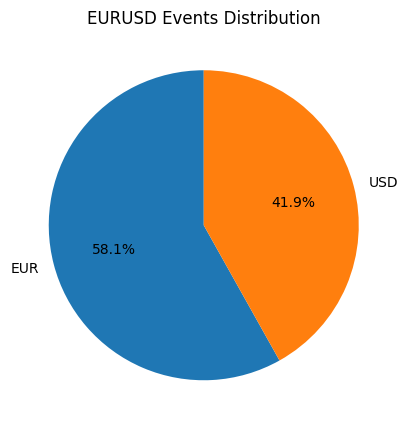

currency
EUR    17170
USD    12369
Name: count, dtype: int64

In [199]:
currency_row_count = frame['currency'].value_counts()
fig,ax = plt.subplots(figsize=(5,8))
ax.pie(currency_row_count, autopct='%1.1f%%', startangle=90,labels=currency_row_count.index)
ax.set_title(DATA + ' Events Distribution')
plt.show()
currency_row_count


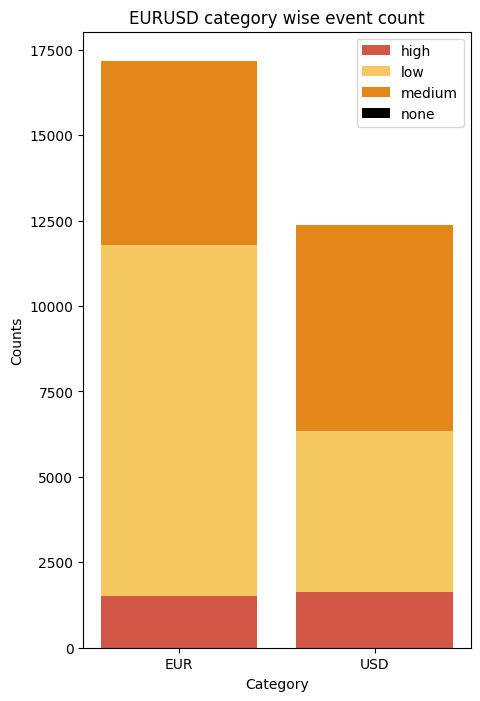

currency  impact
EUR       high       1524
          low       10274
          medium     5369
          none          3
USD       high       1632
          low        4715
          medium     6021
          none          1
Name: count, dtype: int64

In [200]:
currency_impact = frame[['currency','impact']].value_counts().sort_index()
currency_impact_count = frame.groupby(['currency','impact']).size().unstack(fill_value=0)
fig,ax = plt.subplots(figsize=(5,8))
bottom = None
for impact in currency_impact_count.columns:
    if bottom is None:
        p = ax.bar(currency_impact_count.index, currency_impact_count[impact], label=impact,color=IMPACT_COLORS.get(impact))
        bottom = currency_impact_count[impact]
    else:
        p = ax.bar(currency_impact_count.index, currency_impact_count[impact], bottom=bottom, label=impact,color=IMPACT_COLORS.get(impact))
        bottom += currency_impact_count[impact]
ax.set_xlabel('Category')
ax.set_ylabel('Counts')
ax.legend()
ax.set_title( DATA + ' category wise event count')
plt.show()

# currency_impact_count
currency_impact

In [201]:
frame[frame['impact']=='none'].tail()

,currency,description,impact,result,0h,1h,3h,5h,hour_of_day,month_of_year,day_of_week,day_of_month,release_period,quarterly_period
time,,,,,,,,,,,,,,
2015-05-21 12:30:00+00:00,USD,Continuing Jobless Claims,none,green,1.11366,1.11127,1.11189,1.11323,12,5,3,21,Normal,Normal
2015-07-27 08:00:00+00:00,EUR,IFO – Business Climate,none,green,1.10868,1.10777,1.10671,1.10702,8,7,0,27,Normal,Normal
2015-07-27 08:00:00+00:00,EUR,IFO – Current Assessment,none,green,1.10868,1.10777,1.10671,1.10702,8,7,0,27,Normal,Normal
2015-07-27 08:00:00+00:00,EUR,IFO – Expectations,none,green,1.10868,1.10777,1.10671,1.10702,8,7,0,27,Normal,Normal


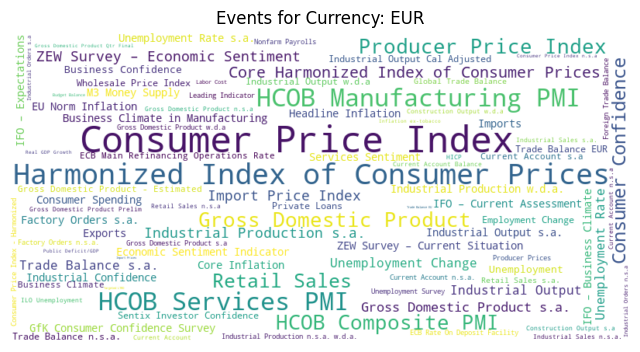

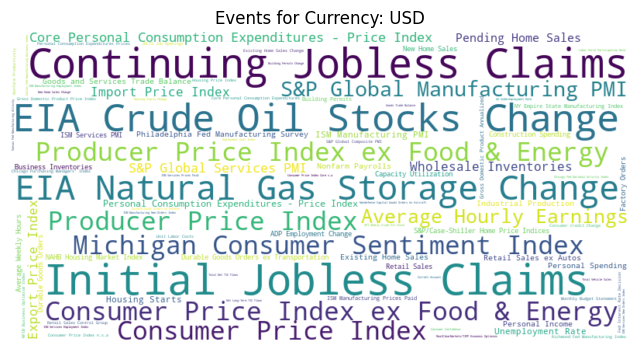

In [202]:

for currency in frame['currency'].unique():
    # Filter descriptions for the current currency
    descriptions = frame[frame['currency'] == currency]['description'].apply(process_description).value_counts()
    d = dict(zip(descriptions.index,descriptions.values))
    # # Generate word frequencies
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(d)
    # Plot the WordCloud
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Events for Currency: {currency}')
    plt.show()

In [203]:
pd.concat([frame['currency'],frame['description'].apply(process_description)], axis=1)[['currency','description']].value_counts().sort_values(ascending=False)

currency  description                        
EUR       Consumer Price Index                   2514
          Harmonized Index of Consumer Prices    1450
          HCOB Services PMI                      1095
          HCOB Manufacturing PMI                 1092
          HCOB Composite PMI                      670
                                                 ... 
          Manufacturing Output                      1
          9-Month Letras Auction                    1
USD       20-Year Bond Auction                      1
          4-Week Bill Auction                       1
EUR       3-Month Letras Auction                    1
Name: count, Length: 195, dtype: int64

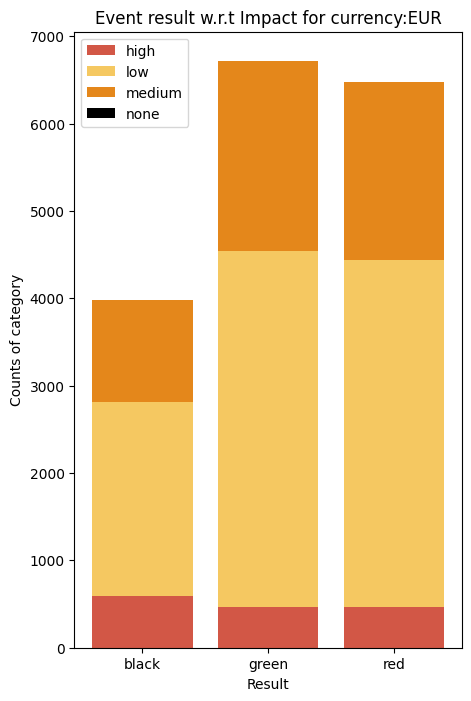

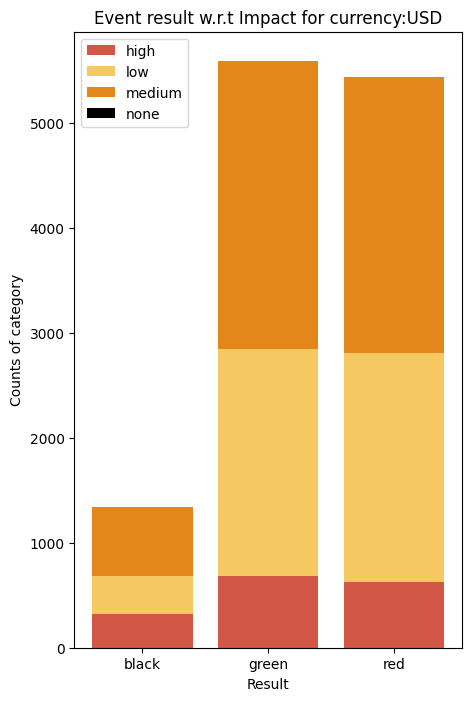

currency  impact  result
EUR       high    black      590
                  green      464
                  red        470
          low     black     2227
                  green     4075
                  red       3972
          medium  black     1158
                  green     2174
                  red       2037
          none    green        3
USD       high    black      324
                  green      685
                  red        623
          low     black      363
                  green     2163
                  red       2189
          medium  black      658
                  green     2741
                  red       2622
          none    green        1
Name: count, dtype: int64

In [204]:
for currency in frame['currency'].unique():
    subframe = frame[frame['currency'] == currency]
    # currency_impact = subframe[['impact','result']].value_counts()
    currency_impact_count = subframe.groupby(['result','impact']).size().unstack(fill_value=0)
    fig,ax = plt.subplots(figsize=(5,8))
    bottom = None
    for impact in currency_impact_count.columns:
        if bottom is None:
            p = ax.bar(currency_impact_count.index, currency_impact_count[impact], label=impact,color=IMPACT_COLORS.get(impact))
            bottom = currency_impact_count[impact]
        else:
            p = ax.bar(currency_impact_count.index, currency_impact_count[impact], bottom=bottom, label=impact,color=IMPACT_COLORS.get(impact))
            bottom += currency_impact_count[impact]
    ax.set_xlabel('Result')
    ax.set_ylabel('Counts of category')
    ax.legend()
    ax.set_title('Event result w.r.t Impact for currency:' + currency)
    plt.show()

    currency_impact_count
    currency_impact
frame[['currency','impact','result']].value_counts().sort_index()

In [205]:
frame.columns

Index(['currency', 'description', 'impact', 'result', '0h', '1h', '3h', '5h',
       'hour_of_day', 'month_of_year', 'day_of_week', 'day_of_month',
       'release_period', 'quarterly_period'],
      dtype='object')

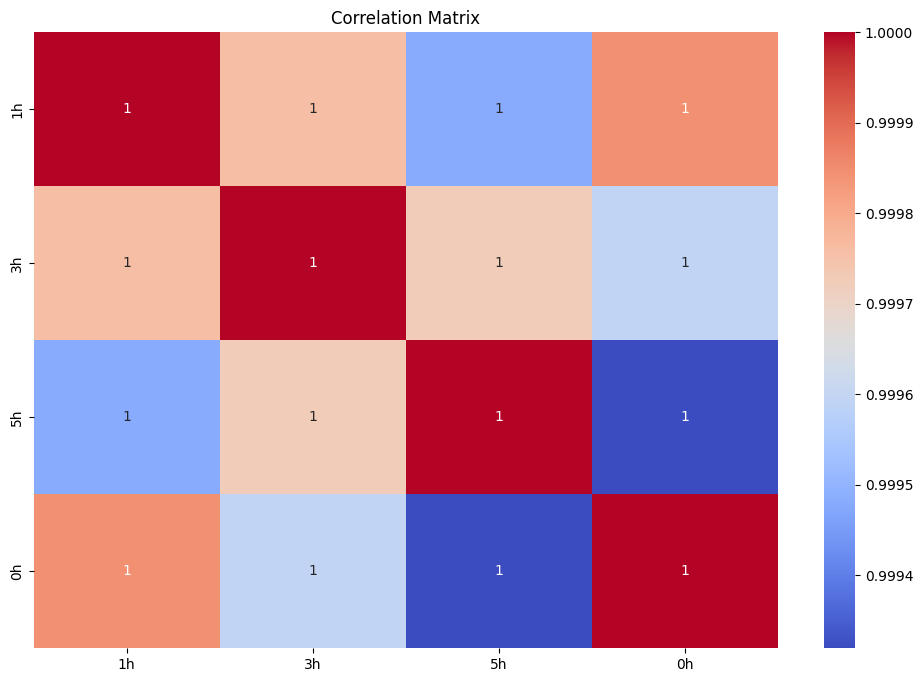

In [206]:
#Visualize the correlation matrix
prices_columns = PREDICTED_FUTURE_PRICES.copy()
prices_columns.append('0h')
plt.figure(figsize=(12, 8))
correlation_matrix = frame[prices_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()



#### Encoder

In [207]:
frame.tail()

,currency,description,impact,result,0h,1h,3h,5h,hour_of_day,month_of_year,day_of_week,day_of_month,release_period,quarterly_period
time,,,,,,,,,,,,,,
2024-06-28 12:30:00+00:00,USD,Personal Income,medium,green,1.06981,1.07179,1.07155,1.07113,12,6,4,28,MoM,Normal
2024-06-28 12:30:00+00:00,USD,Personal Spending,medium,red,1.06981,1.07179,1.07155,1.07113,12,6,4,28,Normal,Normal
2024-06-28 13:45:00+00:00,USD,Chicago Purchasing Managers' Index,medium,green,1.07179,1.07108,1.07139,1.07107,13,6,4,28,Normal,Normal
2024-06-28 14:00:00+00:00,USD,Michigan Consumer Sentiment Index,medium,green,1.07108,1.07155,1.07113,1.07138,14,6,4,28,Normal,Normal
2024-06-28 14:00:00+00:00,USD,UoM 5-year Consumer Inflation Expectation,medium,red,1.07108,1.07155,1.07113,1.07138,14,6,4,28,Normal,Normal


In [208]:
len(frame.description.unique())

185

In [209]:
EVENT_COLUMNS

['time', 'currency', 'description', 'impact', 'result']

In [210]:
# from sklearn.feature_extraction import FeatureHasher

# # Initialize FeatureHasher
# hasher = FeatureHasher(n_features=1000, input_type='string')

# # Transform the 'description' column
# # Prepare data for FeatureHasher
# hashed_descriptions = [
#     [description] for description in frame['description']
# ]
# description_hashed = hasher.transform(hashed_descriptions)

# # Convert to DataFrame (if needed)
# description_df = pd.DataFrame(description_hashed.toarray())

# # Concatenate with original DataFrame
# frame = pd.concat([frame.drop(columns=['description']), description_df], axis=1)


In [211]:
frame.reset_index(inplace=True)

In [212]:
frame.description.unique()
print(len(frame.description.unique()))

185


In [213]:
# labelencoder = LabelEncoder()
# frame['description'] = labelencoder.fit_transform(frame['description'])

# Apply OneHotEncoder to categorical columns
# categorical_columns = ['currency', 'impact', 'result','release_period','quarterly_period']
categorical_columns = ['currency', 'impact', 'result','release_period','quarterly_period','description']
encoder = OneHotEncoder(sparse_output=False)
encoded_categorical_data = encoder.fit_transform(frame[categorical_columns])

# Create DataFrame for the encoded columns
encoded_columns = encoder.get_feature_names_out(categorical_columns)
encoded_categorical_df = pd.DataFrame(encoded_categorical_data, columns=encoded_columns)

# Drop the original categorical columns and concatenate the encoded columns
frame = frame.drop(columns=categorical_columns).reset_index(drop=True)
frame = pd.concat([frame, encoded_categorical_df], axis=1)

print(frame.head())

                       time       0h       1h       3h       5h  hour_of_day  \
0 2013-01-02 09:13:00+00:00  1.32641  1.32448  1.32669  1.32535            9   
1 2013-01-02 09:43:00+00:00  1.32641  1.32448  1.32669  1.32535            9   
2 2013-01-02 09:48:00+00:00  1.32641  1.32448  1.32669  1.32535            9   
3 2013-01-02 09:53:00+00:00  1.32641  1.32448  1.32669  1.32535            9   
4 2013-01-02 09:58:00+00:00  1.32641  1.32448  1.32669  1.32535            9   

   month_of_year  day_of_week  day_of_month  currency_EUR  ...  \
0              1            2             2           1.0  ...   
1              1            2             2           1.0  ...   
2              1            2             2           1.0  ...   
3              1            2             2           1.0  ...   
4              1            2             2           1.0  ...   

   description_Unemployment Rate  description_Unemployment Rate s.a.  \
0                            0.0                  

In [214]:
frame.head()
frame.set_index(pd.to_datetime(frame['time']),inplace=True)
frame.drop(columns=['time'],inplace=True)

In [215]:
frame

,0h,1h,3h,5h,hour_of_day,month_of_year,day_of_week,day_of_month,currency_EUR,currency_USD,...,description_Unemployment Rate,description_Unemployment Rate s.a.,description_Unemployment Survey,description_Unit Labor Costs,description_UoM 5-year Consumer Inflation Expectation,description_Wholesale Inventories,description_Wholesale Price Index,description_Wholesale Prices n.s.a,description_ZEW Survey – Current Situation,description_ZEW Survey – Economic Sentiment
time,,,,,,,,,,,,,,,,,,,,,
2013-01-02 09:13:00+00:00,1.32641,1.32448,1.32669,1.32535,9,1,2,2,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02 09:43:00+00:00,1.32641,1.32448,1.32669,1.32535,9,1,2,2,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02 09:48:00+00:00,1.32641,1.32448,1.32669,1.32535,9,1,2,2,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02 09:53:00+00:00,1.32641,1.32448,1.32669,1.32535,9,1,2,2,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02 09:58:00+00:00,1.32641,1.32448,1.32669,1.32535,9,1,2,2,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-28 12:30:00+00:00,1.06981,1.07179,1.07155,1.07113,12,6,4,28,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-06-28 12:30:00+00:00,1.06981,1.07179,1.07155,1.07113,12,6,4,28,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-06-28 13:45:00+00:00,1.07179,1.07108,1.07139,1.07107,13,6,4,28,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [216]:
frame

,0h,1h,3h,5h,hour_of_day,month_of_year,day_of_week,day_of_month,currency_EUR,currency_USD,...,description_Unemployment Rate,description_Unemployment Rate s.a.,description_Unemployment Survey,description_Unit Labor Costs,description_UoM 5-year Consumer Inflation Expectation,description_Wholesale Inventories,description_Wholesale Price Index,description_Wholesale Prices n.s.a,description_ZEW Survey – Current Situation,description_ZEW Survey – Economic Sentiment
time,,,,,,,,,,,,,,,,,,,,,
2013-01-02 09:13:00+00:00,1.32641,1.32448,1.32669,1.32535,9,1,2,2,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02 09:43:00+00:00,1.32641,1.32448,1.32669,1.32535,9,1,2,2,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02 09:48:00+00:00,1.32641,1.32448,1.32669,1.32535,9,1,2,2,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02 09:53:00+00:00,1.32641,1.32448,1.32669,1.32535,9,1,2,2,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02 09:58:00+00:00,1.32641,1.32448,1.32669,1.32535,9,1,2,2,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-28 12:30:00+00:00,1.06981,1.07179,1.07155,1.07113,12,6,4,28,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-06-28 12:30:00+00:00,1.06981,1.07179,1.07155,1.07113,12,6,4,28,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-06-28 13:45:00+00:00,1.07179,1.07108,1.07139,1.07107,13,6,4,28,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Encoding the columns

In [217]:
columns = frame.columns.values.tolist()
for item in PREDICTED_FUTURE_PRICES:
    columns.remove(item)
columns

['0h',
 'hour_of_day',
 'month_of_year',
 'day_of_week',
 'day_of_month',
 'currency_EUR',
 'currency_USD',
 'impact_high',
 'impact_low',
 'impact_medium',
 'impact_none',
 'result_black',
 'result_green',
 'result_red',
 'release_period_MoM',
 'release_period_Normal',
 'release_period_QoQ',
 'release_period_YoY',
 'quarterly_period_Normal',
 'quarterly_period_Q1',
 'quarterly_period_Q2',
 'quarterly_period_Q3',
 'quarterly_period_Q4',
 'description_20-Year Bond Auction',
 'description_3-Month Letras Auction',
 'description_4-Week Bill Auction',
 'description_9-Month Letras Auction',
 'description_ADP Employment Change',
 'description_API Weekly Crude Oil Stock',
 'description_Average Hourly Earnings',
 'description_Average Weekly Hours',
 'description_Budget Balance',
 'description_Building Permits',
 'description_Building Permits Change',
 'description_Business Climate',
 'description_Business Climate in Manufacturing',
 'description_Business Confidence',
 'description_Business Inve

In [218]:
frame[columns]

,0h,hour_of_day,month_of_year,day_of_week,day_of_month,currency_EUR,currency_USD,impact_high,impact_low,impact_medium,...,description_Unemployment Rate,description_Unemployment Rate s.a.,description_Unemployment Survey,description_Unit Labor Costs,description_UoM 5-year Consumer Inflation Expectation,description_Wholesale Inventories,description_Wholesale Price Index,description_Wholesale Prices n.s.a,description_ZEW Survey – Current Situation,description_ZEW Survey – Economic Sentiment
time,,,,,,,,,,,,,,,,,,,,,
2013-01-02 09:13:00+00:00,1.32641,9,1,2,2,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02 09:43:00+00:00,1.32641,9,1,2,2,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02 09:48:00+00:00,1.32641,9,1,2,2,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02 09:53:00+00:00,1.32641,9,1,2,2,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02 09:58:00+00:00,1.32641,9,1,2,2,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-28 12:30:00+00:00,1.06981,12,6,4,28,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-06-28 12:30:00+00:00,1.06981,12,6,4,28,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-06-28 13:45:00+00:00,1.07179,13,6,4,28,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [219]:
frame.head()

,0h,1h,3h,5h,hour_of_day,month_of_year,day_of_week,day_of_month,currency_EUR,currency_USD,...,description_Unemployment Rate,description_Unemployment Rate s.a.,description_Unemployment Survey,description_Unit Labor Costs,description_UoM 5-year Consumer Inflation Expectation,description_Wholesale Inventories,description_Wholesale Price Index,description_Wholesale Prices n.s.a,description_ZEW Survey – Current Situation,description_ZEW Survey – Economic Sentiment
time,,,,,,,,,,,,,,,,,,,,,
2013-01-02 09:13:00+00:00,1.32641,1.32448,1.32669,1.32535,9,1,2,2,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02 09:43:00+00:00,1.32641,1.32448,1.32669,1.32535,9,1,2,2,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02 09:48:00+00:00,1.32641,1.32448,1.32669,1.32535,9,1,2,2,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02 09:53:00+00:00,1.32641,1.32448,1.32669,1.32535,9,1,2,2,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02 09:58:00+00:00,1.32641,1.32448,1.32669,1.32535,9,1,2,2,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [220]:
PREDICTED_FUTURE_PRICES

['1h', '3h', '5h']

In [221]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

frame.sort_index(inplace=True)



# features = frame[columns] # Add more features as needed
# target_1h = frame['1h']
# target_3h = frame['3h']
# target_5h = frame['5h']



# # Split data into training and testing sets
# X_train, X_test, y_train_1h, y_test_1h = train_test_split(features, target_1h, test_size=0.2, random_state=42)
# _, _, y_train_3h, y_test_3h = train_test_split(features, target_3h, test_size=0.2, random_state=42)
# _, _, y_train_5h, y_test_5h = train_test_split(features, target_5h, test_size=0.2, random_state=42)



# train, test = frame[:train_size], frame[train_size:]


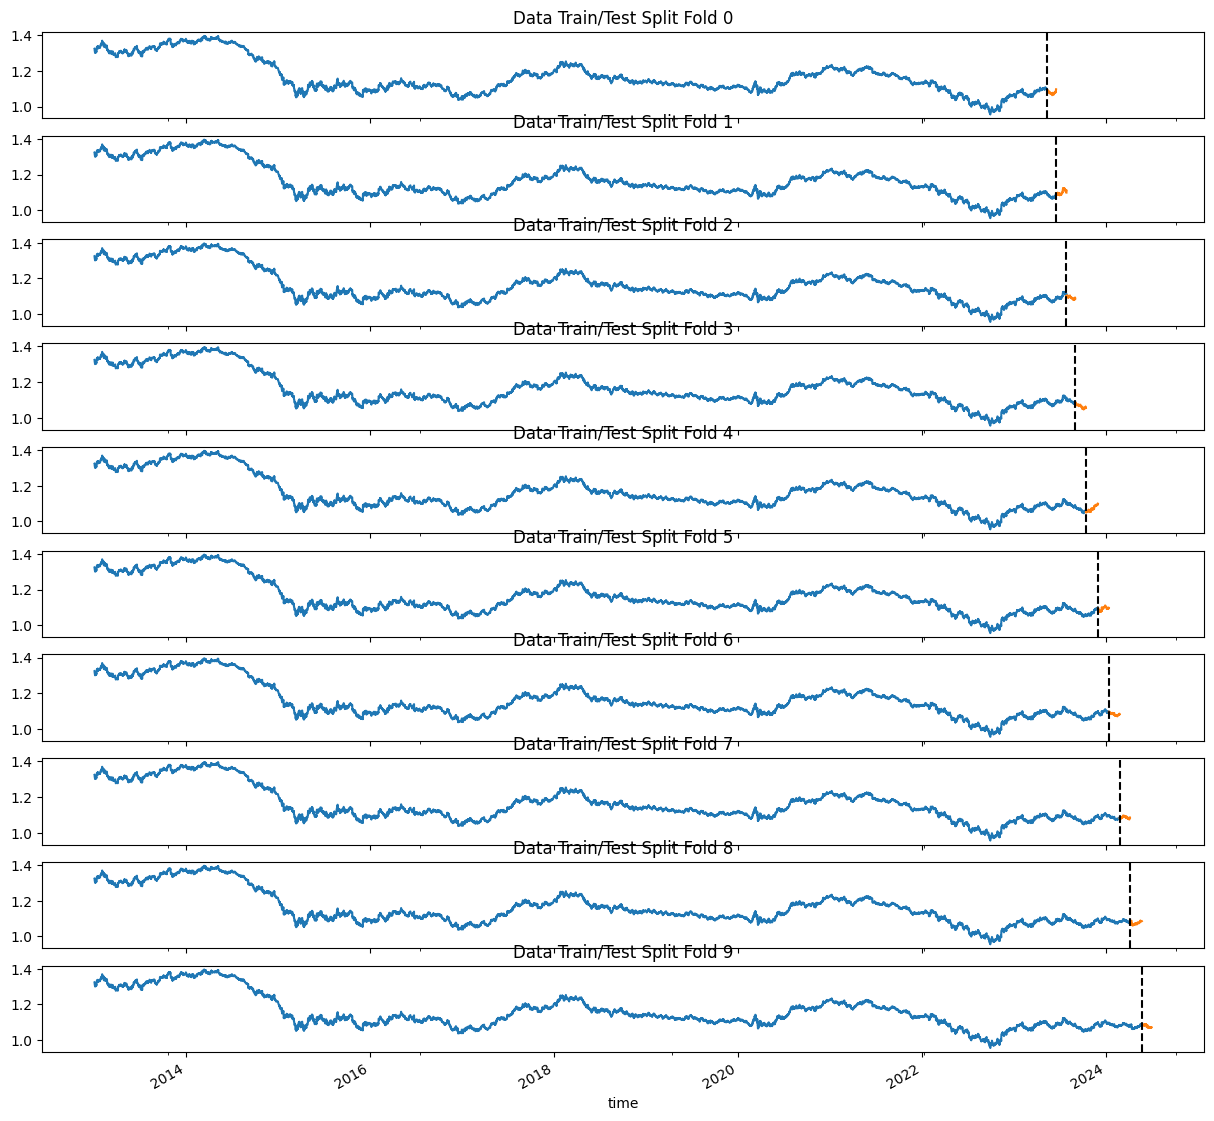

In [222]:
folds= 10
tss = TimeSeriesSplit(n_splits=folds,test_size=300)



fig, axs = plt.subplots(folds, 1, figsize=(15, 15), sharex=True)
fold = 0
for train_idx , val_idx in tss.split(frame):
    train = frame.iloc[train_idx]
    test = frame.iloc[val_idx]
    train['1h'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['1h'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [223]:
import itertools as it
TRAIN_TEST_LABEL = ['train','test']

# scaler = StandardScaler()
# frame = scaler.fit_transform(frame)

In [224]:
# Calculate accuracy metrics

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
r2_scores = {}
mse_scores = {}
mae_scores = {}
rmse_scores ={}

def reset_evaluation_matrics():
    global r2_scores, mse_scores, mae_scores, rmse_scores
    r2_scores = {}
    mse_scores = {}
    mae_scores = {}
    rmse_scores ={}
    for item in it.product(PREDICTED_FUTURE_PRICES,TRAIN_TEST_LABEL):
        item = '_'.join(item)
        r2_scores[item] , mse_scores[item] , mae_scores[item] , rmse_scores[item] = [] , [], [], []
    # print_vars()

def print_metrics(y_true, y_pred, label):
    global r2_scores, mse_scores, mae_scores, rmse_scores
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2_scores[label].append(r2)
    mse_scores[label].append(mse)
    mae_scores[label].append(mae)
    rmse_scores[label].append(rmse)
    print(f'{label} - R^2: {r2:.4f}')
    print(f'{label} - Mean Absolute Error (MAE): {mae:.4f}')
    print(f'{label} - Mean Squared Error (MSE): {mse:.4f}')
    print(f'{label} - Root Mean Squared Error (RMSE): {rmse:.4f}')
    print('-------------------------------------------')
    # print_vars()
    print('------------------------------------------')

    return (r2,mae,mse,rmse)


def print_vars():
    global r2_scores, mse_scores, mae_scores, rmse_scores
    print(r2_scores)
    print(mse_scores)
    print(mae_scores)
    print(rmse_scores)

In [225]:
 # X_train = scaler.fit_transform(X_train)
        # X_test = scaler.transform(X_test)
        # pca = PCA(n_components=0.95)  # Retain 95% of variance
        # X_train = pca.fit_transform(X_train)
        # X_test = pca.transform(X_test)
        # print(X_train)




 # y_train_3h, y_test_3h = target_3h.iloc[train_index], target_3h.iloc[test_index]
            # y_train_5h, y_test_5h = target_5h.iloc[train_index], target_5h.iloc[test_index]
        # print(y_train_1h)
        # print(y_test_1h)

In [226]:
def feature_selection(X,y):
    lasso = Lasso(alpha=0.1)  # Increased regularization
    lasso.fit(X, y)
    selected_features = X.columns[(lasso.coef_ != 0)]
    print(selected_features)
    return selected_features

In [227]:
 # X_train = scaler.fit_transform(X_train)
        # X_test = scaler.transform(X_test)
        # pca = PCA(n_components=0.95)  # Retain 95% of variance
        # X_train = pca.fit_transform(X_train)
        # X_test = pca.transform(X_test)

In [228]:
from statistics import mean


from sklearn.decomposition import PCA

def model_training(model_function):
    scaler = StandardScaler()
    pca = PCA(n_components=0.95)  # Adjust n_components as needed
    reset_evaluation_matrics()
    print_vars()
    features = frame[columns]
    for train_index, test_index in tss.split(frame):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]  
        # X_train_pca = pca.fit_transform(X_train_scaled)
        # X_test_pca = pca.transform(X_test_scaled)
        for label in PREDICTED_FUTURE_PRICES:
             # Add more features as needed
            target = frame[label]
            y_train, y_test = target.iloc[train_index], target.iloc[test_index]
            # feature_selection(X_train,y_train)
            model_function(X_train,X_test,y_train,y_test,label)

    for label in it.product(PREDICTED_FUTURE_PRICES,TRAIN_TEST_LABEL):
        label = '_'.join(label)
        print(f'Final Scores for {label} prices')
        print(f'{label} - R^2: {mean(r2_scores[label]):.4f}')
        print(f'{label} - Mean Absolute Error (MAE): {mean(mae_scores[label]):.4f}')
        print(f'{label} - Mean Squared Error (MSE): {mean(mse_scores[label]):.4f}')
        print(f'{label} - Root Mean Squared Error (RMSE): {mean(rmse_scores[label]):.4f}')
        print('-----------------------------------------------------------------------------------------------------')
 

In [229]:
# from sklearn.linear_model import LinearRegression

# train_size = int(len(frame.index.normalize().unique()) * 0.95)

# # Define the start and end dates for the training period
# window_size_days = train_size  # Number of days in each training set
# step_size_days = 1    # Number of days to move the window
# reset_evaluation_matrics()
# # Get unique days

# unique_days = frame.index.normalize().unique()
# print(len(unique_days))
# for i in range(window_size_days, len(unique_days)):
#     # Training period
#     train_start_day = unique_days[0]
#     train_end_day = unique_days[i] - pd.Timedelta(seconds=1)
#     # print(train_start_day)
#     # print(train_end_day)
#     # Test period
#     test_start_day = unique_days[i]
#     test_end_day = unique_days[i] + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)

#     print(train_start_day)
#     print(train_end_day)
#     print(test_start_day)
#     print(test_end_day)
#     print()
#     # Slice the DataFrame using date ranges
#     X_train = features[train_start_day:train_end_day]
#     X_test = features[test_start_day:test_end_day]
#     y_train_1h, y_test_1h = target_1h[train_start_day:train_end_day], target_1h[test_start_day:test_end_day]
#     y_train_3h, y_test_3h = target_3h[train_start_day:train_end_day], target_3h[test_start_day:test_end_day]
#     y_train_5h, y_test_5h = target_5h[train_start_day:train_end_day], target_5h[test_start_day:test_end_day]


#     model_1h = LinearRegression()
#     model_3h = LinearRegression()
#     model_5h = LinearRegression()

#     model_1h.fit(X_train, y_train_1h)
#     model_3h.fit(X_train, y_train_3h)
#     model_5h.fit(X_train, y_train_5h)

#     # Predict and evaluate
#     y_pred_1h = model_1h.predict(X_test)
#     y_pred_3h = model_3h.predict(X_test)
#     y_pred_5h = model_5h.predict(X_test)

#     # print("Intercept:",model_1h.intercept_ ,"\nCoefficients:",model_1h.coef_)
#     # print("Intercept:",model_3h.intercept_ ,"\nCoefficients:",model_3h.coef_)
#     # print("Intercept:",model_5h.intercept_ ,"\nCoefficients:",model_5h.coef_)
#     print_metrics(y_test_1h,y_pred_1h,'1h_test')
#     print_metrics(y_test_3h,y_pred_3h,'3h_test')
#     print_metrics(y_test_5h,y_pred_5h,'5h_test')

In [230]:
# from sklearn.ensemble import RandomForestRegressor
# # Rolling forecast origin parameters
# initial_training_days = train_size  # Initial number of days in the training set
# test_window_days = 1       # Number of days in the test set

# # Get unique days
# unique_days = frame.index.normalize().unique()

# # Initialize lists to store the train and test indices
# train_indices = []
# test_indices = []

# # Create rolling forecast origin windows
# for i in range(initial_training_days, len(unique_days)):
#     # Training period
#     train_start_day = unique_days[0]
#     train_end_day = unique_days[i] - pd.Timedelta(seconds=1)
    
#     # Test period
#     test_start_day = unique_days[i]
#     test_end_day = unique_days[i] + pd.Timedelta(days=test_window_days) - pd.Timedelta(seconds=1)
    
#     # Slice the DataFrame using date ranges
#     train = frame[train_start_day:train_end_day]
#     test = frame[test_start_day:test_end_day ]
    
#     print(train_start_day)
#     print(train_end_day)
#     print(test_start_day)
#     print(test_end_day)
#     print()

#     # Train a Random Forest model for each target
#     model_1h = RandomForestRegressor(random_state=42)
#     model_3h = RandomForestRegressor(random_state=42)
#     model_5h = RandomForestRegressor(random_state=42)

#     model_1h.fit(X_train, y_train_1h)
#     model_3h.fit(X_train, y_train_3h)
#     model_5h.fit(X_train, y_train_5h)

#     # Predict and evaluate
#     y_pred_1h = model_1h.predict(X_test)
#     y_pred_3h = model_3h.predict(X_test)
#     y_pred_5h = model_5h.predict(X_test)

#     print_metrics(y_test_1h,y_pred_1h,'1h')
#     print_metrics(y_test_3h,y_pred_3h,'3h')
#     print_metrics(y_test_5h,y_pred_5h,'5h')
   
    


In [231]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge


def regulization(X_train,X_test,y_train_1h,y_train_3h,y_train_5h,y_test_1h,y_test_3h,y_test_5h):
    alpha = 1.0  # Regularization strength
    lasso_reg = Lasso(alpha=alpha)
    lasso_reg.fit(X_train, y_train_1h)

    # Define a range of alpha values to test
    alpha_values = {'alpha': [0.01, 0.1, 1, 10, 100]}

    # Ridge Regression
    ridge = Ridge()
    ridge_cv = GridSearchCV(ridge, alpha_values, cv=5)
    ridge_cv.fit(X_train, y_train_1h)

    # Lasso Regression
    lasso = Lasso()
    lasso_cv = GridSearchCV(lasso, alpha_values, cv=5)
    lasso_cv.fit(X_train, y_train_1h)

    # Best alpha value
    print(f"Best alpha for Ridge: {ridge_cv.best_params_}")
    print(f"Best alpha for Lasso: {lasso_cv.best_params_}")


In [232]:
# model_training(regulization)

In [233]:
from sklearn.model_selection import cross_val_score
def cross_valization_cal(model,X,Y):
    cv_scores = cross_val_score(model, X, Y, cv=5)
    print(f"Cross-Validation R^2 scores: {cv_scores}")
    print(f"Mean Cross-Validation R^2: {cv_scores.mean()}")

In [234]:
from sklearn.linear_model import LinearRegression

def linear_regression_model(X_train,X_test,y_train,y_test,label):
    model = LinearRegression()
    model.fit(X_train, y_train)
    # Predict and evaluate for train data data
    y_pred_train = model.predict(X_train)
    # Predict and evaluate for test data
    y_pred_test = model.predict(X_test)
    # cross_valization_cal(model,X_train,y_pred_train)
    print_metrics(y_train,y_pred_train,label+'_train')
    print_metrics(y_test,y_pred_test,label+'_test')

In [235]:
model_training(linear_regression_model)

{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
1h_train - R^2: 0.9997
1h_train - Mean Absolute Error (MAE): 0.0011
1h_train - Mean Squared Error (MSE): 0.0000
1h_train - Root Mean Squared Error (RMSE): 0.0016
-------------------------------------------
------------------------------------------
1h_test - R^2: 0.9754
1h_test - Mean Absolute Error (MAE): 0.0010
1h_test - Mean Squared Error (MSE): 0.0000
1h_test - Root Mean Squared Error (RMSE): 0.0012
-------------------------------------------
------------------------------------------
3h_train - R^2: 0.9992
3h_train - Mean Absolute Error (MAE): 0.0018
3h_train - Mean Squared Error (MSE): 0.0000
3h_train - Root Me

In [236]:
from sklearn.tree import DecisionTreeRegressor

def decision_tree_reg_model(X_train,X_test,y_train,y_test,label):
    model = DecisionTreeRegressor(random_state=42)
    model.fit(X_train, y_train)
    # Predict and evaluate for train data data
    y_pred_train = model.predict(X_train)
    # Predict and evaluate for test data
    y_pred_test = model.predict(X_test)
    # cross_valization_cal(model,X_train,y_pred_train)
    print_metrics(y_train,y_pred_train,label+'_train')
    print_metrics(y_test,y_pred_test,label+'_test')



In [237]:
model_training(decision_tree_reg_model)

{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
1h_train - R^2: 1.0000
1h_train - Mean Absolute Error (MAE): 0.0000
1h_train - Mean Squared Error (MSE): 0.0000
1h_train - Root Mean Squared Error (RMSE): 0.0000
-------------------------------------------
------------------------------------------
1h_test - R^2: 0.9349
1h_test - Mean Absolute Error (MAE): 0.0015
1h_test - Mean Squared Error (MSE): 0.0000
1h_test - Root Mean Squared Error (RMSE): 0.0020
-------------------------------------------
------------------------------------------
3h_train - R^2: 1.0000
3h_train - Mean Absolute Error (MAE): 0.0000
3h_train - Mean Squared Error (MSE): 0.0000
3h_train - Root Me

In [238]:
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest model for each target
def random_forest_regressor_model(X_train,X_test,y_train,y_test,label):
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    # Predict and evaluate for train data data
    y_pred_train = model.predict(X_train)
    # Predict and evaluate for test data
    y_pred_test = model.predict(X_test)
    # cross_valization_cal(model,X_train,y_pred_train)
    print_metrics(y_train,y_pred_train,label+'_train')
    print_metrics(y_test,y_pred_test,label+'_test')


In [239]:
model_training(random_forest_regressor_model)

{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
1h_train - R^2: 1.0000
1h_train - Mean Absolute Error (MAE): 0.0002
1h_train - Mean Squared Error (MSE): 0.0000
1h_train - Root Mean Squared Error (RMSE): 0.0004
-------------------------------------------
------------------------------------------
1h_test - R^2: 0.9686
1h_test - Mean Absolute Error (MAE): 0.0012
1h_test - Mean Squared Error (MSE): 0.0000
1h_test - Root Mean Squared Error (RMSE): 0.0014
-------------------------------------------
------------------------------------------
3h_train - R^2: 1.0000
3h_train - Mean Absolute Error (MAE): 0.0003
3h_train - Mean Squared Error (MSE): 0.0000
3h_train - Root Me

In [240]:
import xgboost as xgb
def xgb_regressor_model(X_train,X_test,y_train,y_test,label):
    model = xgb.XGBRegressor(random_state=42)
    model.fit(X_train, y_train)
    # Predict and evaluate for train data data
    y_pred_train = model.predict(X_train)
    # Predict and evaluate for test data
    y_pred_test = model.predict(X_test)
    # cross_valization_cal(model,X_train,y_pred_train)
    print_metrics(y_train,y_pred_train,label+'_train')
    print_metrics(y_test,y_pred_test,label+'_test')


In [241]:
model_training(xgb_regressor_model)

{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
1h_train - R^2: 0.9998
1h_train - Mean Absolute Error (MAE): 0.0010
1h_train - Mean Squared Error (MSE): 0.0000
1h_train - Root Mean Squared Error (RMSE): 0.0014
-------------------------------------------
------------------------------------------
1h_test - R^2: 0.9699
1h_test - Mean Absolute Error (MAE): 0.0011
1h_test - Mean Squared Error (MSE): 0.0000
1h_test - Root Mean Squared Error (RMSE): 0.0014
-------------------------------------------
------------------------------------------
3h_train - R^2: 0.9995
3h_train - Mean Absolute Error (MAE): 0.0015
3h_train - Mean Squared Error (MSE): 0.0000
3h_train - Root Me

In [ ]:
from sklearn.svm import SVR

def support_vector_regressor_model(X_train,X_test,y_train,y_test,label):
    # Train an SVR model for each targeT
    model = xgb.SVR(random_state=42)
    model.fit(X_train, y_train)
    # Predict and evaluate for train data data
    y_pred_train = model.predict(X_train)
    # Predict and evaluate for test data
    y_pred_test = model.predict(X_test)
    # cross_valization_cal(model,X_train,y_pred_train)
    print_metrics(y_train,y_pred_train,label+'_train')
    print_metrics(y_test,y_pred_test,label+'_test')


In [ ]:
# model_training(support_vector_regressor_model)

In [242]:

scaler = StandardScaler()
from tensorflow.keras.regularizers import l2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


def create_model(X_train_scaled):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu',kernel_regularizer=l2(0.01)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def neural_network_model(X_train,X_test,y_train,y_test,label):
    # Standardize the features
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # Train a neural network model for each target
    model = create_model(X_train)
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
    # Predict and evaluate for train data data
    y_pred_train = model.predict(X_train)
    # Predict and evaluate for test data
    y_pred_test = model.predict(X_test)
    print_metrics(y_train,y_pred_train,label+'_train')
    print_metrics(y_test,y_pred_test,label+'_test')



In [243]:
model_training(neural_network_model)

{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}


e:\fxstreet\forex-economic-analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


830/830 ━━━━━━━━━━━━━━━━━━━━ 1s 723us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
1h_train - R^2: 0.9573
1h_train - Mean Absolute Error (MAE): 0.0085
1h_train - Mean Squared Error (MSE): 0.0004
1h_train - Root Mean Squared Error (RMSE): 0.0191
-------------------------------------------
------------------------------------------
1h_test - R^2: -3.2111
1h_test - Mean Absolute Error (MAE): 0.0086
1h_test - Mean Squared Error (MSE): 0.0003
1h_test - Root Mean Squared Error (RMSE): 0.0163
-------------------------------------------
------------------------------------------


e:\fxstreet\forex-economic-analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


830/830 ━━━━━━━━━━━━━━━━━━━━ 1s 864us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3h_train - R^2: 0.9699
3h_train - Mean Absolute Error (MAE): 0.0094
3h_train - Mean Squared Error (MSE): 0.0003
3h_train - Root Mean Squared Error (RMSE): 0.0160
-------------------------------------------
------------------------------------------
3h_test - R^2: -3.2019
3h_test - Mean Absolute Error (MAE): 0.0099
3h_test - Mean Squared Error (MSE): 0.0003
3h_test - Root Mean Squared Error (RMSE): 0.0166
-------------------------------------------
------------------------------------------


e:\fxstreet\forex-economic-analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


830/830 ━━━━━━━━━━━━━━━━━━━━ 1s 783us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5h_train - R^2: 0.9465
5h_train - Mean Absolute Error (MAE): 0.0127
5h_train - Mean Squared Error (MSE): 0.0005
5h_train - Root Mean Squared Error (RMSE): 0.0214
-------------------------------------------
------------------------------------------
5h_test - R^2: -5.3788
5h_test - Mean Absolute Error (MAE): 0.0126
5h_test - Mean Squared Error (MSE): 0.0004
5h_test - Root Mean Squared Error (RMSE): 0.0201
-------------------------------------------
------------------------------------------


e:\fxstreet\forex-economic-analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 770us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1h_train - R^2: 0.9560
1h_train - Mean Absolute Error (MAE): 0.0103
1h_train - Mean Squared Error (MSE): 0.0004
1h_train - Root Mean Squared Error (RMSE): 0.0193
-------------------------------------------
------------------------------------------
1h_test - R^2: -2.2854
1h_test - Mean Absolute Error (MAE): 0.0112
1h_test - Mean Squared Error (MSE): 0.0005
1h_test - Root Mean Squared Error (RMSE): 0.0230
-------------------------------------------
------------------------------------------


e:\fxstreet\forex-economic-analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 794us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3h_train - R^2: 0.9734
3h_train - Mean Absolute Error (MAE): 0.0091
3h_train - Mean Squared Error (MSE): 0.0002
3h_train - Root Mean Squared Error (RMSE): 0.0151
-------------------------------------------
------------------------------------------
3h_test - R^2: -0.6908
3h_test - Mean Absolute Error (MAE): 0.0100
3h_test - Mean Squared Error (MSE): 0.0003
3h_test - Root Mean Squared Error (RMSE): 0.0164
-------------------------------------------
------------------------------------------


e:\fxstreet\forex-economic-analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5h_train - R^2: 0.9752
5h_train - Mean Absolute Error (MAE): 0.0084
5h_train - Mean Squared Error (MSE): 0.0002
5h_train - Root Mean Squared Error (RMSE): 0.0145
-------------------------------------------
------------------------------------------
5h_test - R^2: -0.4523
5h_test - Mean Absolute Error (MAE): 0.0085
5h_test - Mean Squared Error (MSE): 0.0002
5h_test - Root Mean Squared Error (RMSE): 0.0151
-------------------------------------------
------------------------------------------


e:\fxstreet\forex-economic-analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


849/849 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1h_train - R^2: 0.9563
1h_train - Mean Absolute Error (MAE): 0.0085
1h_train - Mean Squared Error (MSE): 0.0004
1h_train - Root Mean Squared Error (RMSE): 0.0192
-------------------------------------------
------------------------------------------
1h_test - R^2: -5.0251
1h_test - Mean Absolute Error (MAE): 0.0090
1h_test - Mean Squared Error (MSE): 0.0003
1h_test - Root Mean Squared Error (RMSE): 0.0164
-------------------------------------------
------------------------------------------


e:\fxstreet\forex-economic-analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


849/849 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3h_train - R^2: 0.9618
3h_train - Mean Absolute Error (MAE): 0.0100
3h_train - Mean Squared Error (MSE): 0.0003
3h_train - Root Mean Squared Error (RMSE): 0.0180
-------------------------------------------
------------------------------------------
3h_test - R^2: -6.9239
3h_test - Mean Absolute Error (MAE): 0.0103
3h_test - Mean Squared Error (MSE): 0.0004
3h_test - Root Mean Squared Error (RMSE): 0.0192
-------------------------------------------
------------------------------------------


e:\fxstreet\forex-economic-analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


849/849 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
5h_train - R^2: 0.9531
5h_train - Mean Absolute Error (MAE): 0.0135
5h_train - Mean Squared Error (MSE): 0.0004
5h_train - Root Mean Squared Error (RMSE): 0.0199
-------------------------------------------
------------------------------------------
5h_test - R^2: -6.4556
5h_test - Mean Absolute Error (MAE): 0.0142
5h_test - Mean Squared Error (MSE): 0.0004
5h_test - Root Mean Squared Error (RMSE): 0.0187
-------------------------------------------
------------------------------------------


e:\fxstreet\forex-economic-analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 758us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1h_train - R^2: 0.9613
1h_train - Mean Absolute Error (MAE): 0.0082
1h_train - Mean Squared Error (MSE): 0.0003
1h_train - Root Mean Squared Error (RMSE): 0.0181
-------------------------------------------
------------------------------------------
1h_test - R^2: -3.5274
1h_test - Mean Absolute Error (MAE): 0.0084
1h_test - Mean Squared Error (MSE): 0.0005
1h_test - Root Mean Squared Error (RMSE): 0.0217
-------------------------------------------
------------------------------------------


e:\fxstreet\forex-economic-analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
3h_train - R^2: 0.9654
3h_train - Mean Absolute Error (MAE): 0.0094
3h_train - Mean Squared Error (MSE): 0.0003
3h_train - Root Mean Squared Error (RMSE): 0.0171
-------------------------------------------
------------------------------------------
3h_test - R^2: -4.5519
3h_test - Mean Absolute Error (MAE): 0.0093
3h_test - Mean Squared Error (MSE): 0.0005
3h_test - Root Mean Squared Error (RMSE): 0.0233
-------------------------------------------
------------------------------------------


e:\fxstreet\forex-economic-analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 722us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
5h_train - R^2: 0.9639
5h_train - Mean Absolute Error (MAE): 0.0115
5h_train - Mean Squared Error (MSE): 0.0003
5h_train - Root Mean Squared Error (RMSE): 0.0174
-------------------------------------------
------------------------------------------
5h_test - R^2: -4.2476
5h_test - Mean Absolute Error (MAE): 0.0114
5h_test - Mean Squared Error (MSE): 0.0005
5h_test - Root Mean Squared Error (RMSE): 0.0225
-------------------------------------------
------------------------------------------


e:\fxstreet\forex-economic-analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1h_train - R^2: 0.9661
1h_train - Mean Absolute Error (MAE): 0.0088
1h_train - Mean Squared Error (MSE): 0.0003
1h_train - Root Mean Squared Error (RMSE): 0.0169
-------------------------------------------
------------------------------------------
1h_test - R^2: -0.8909
1h_test - Mean Absolute Error (MAE): 0.0087
1h_test - Mean Squared Error (MSE): 0.0004
1h_test - Root Mean Squared Error (RMSE): 0.0193
-------------------------------------------
------------------------------------------


e:\fxstreet\forex-economic-analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 770us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
3h_train - R^2: 0.9636
3h_train - Mean Absolute Error (MAE): 0.0083
3h_train - Mean Squared Error (MSE): 0.0003
3h_train - Root Mean Squared Error (RMSE): 0.0175
-------------------------------------------
------------------------------------------
3h_test - R^2: 0.3123
3h_test - Mean Absolute Error (MAE): 0.0078
3h_test - Mean Squared Error (MSE): 0.0001
3h_test - Root Mean Squared Error (RMSE): 0.0119
-------------------------------------------
------------------------------------------


e:\fxstreet\forex-economic-analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 818us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
5h_train - R^2: 0.9686
5h_train - Mean Absolute Error (MAE): 0.0088
5h_train - Mean Squared Error (MSE): 0.0003
5h_train - Root Mean Squared Error (RMSE): 0.0163
-------------------------------------------
------------------------------------------
5h_test - R^2: 0.4263
5h_test - Mean Absolute Error (MAE): 0.0071
5h_test - Mean Squared Error (MSE): 0.0001
5h_test - Root Mean Squared Error (RMSE): 0.0110
-------------------------------------------
------------------------------------------


e:\fxstreet\forex-economic-analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


877/877 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1h_train - R^2: 0.9433
1h_train - Mean Absolute Error (MAE): 0.0166
1h_train - Mean Squared Error (MSE): 0.0005
1h_train - Root Mean Squared Error (RMSE): 0.0218
-------------------------------------------
------------------------------------------
1h_test - R^2: -3.5352
1h_test - Mean Absolute Error (MAE): 0.0138
1h_test - Mean Squared Error (MSE): 0.0003
1h_test - Root Mean Squared Error (RMSE): 0.0169
-------------------------------------------
------------------------------------------


e:\fxstreet\forex-economic-analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


877/877 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
3h_train - R^2: 0.9582
3h_train - Mean Absolute Error (MAE): 0.0109
3h_train - Mean Squared Error (MSE): 0.0004
3h_train - Root Mean Squared Error (RMSE): 0.0188
-------------------------------------------
------------------------------------------
3h_test - R^2: -3.3138
3h_test - Mean Absolute Error (MAE): 0.0106
3h_test - Mean Squared Error (MSE): 0.0003
3h_test - Root Mean Squared Error (RMSE): 0.0164
-------------------------------------------
------------------------------------------


e:\fxstreet\forex-economic-analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


877/877 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5h_train - R^2: 0.9585
5h_train - Mean Absolute Error (MAE): 0.0099
5h_train - Mean Squared Error (MSE): 0.0003
5h_train - Root Mean Squared Error (RMSE): 0.0187
-------------------------------------------
------------------------------------------
5h_test - R^2: -2.5934
5h_test - Mean Absolute Error (MAE): 0.0081
5h_test - Mean Squared Error (MSE): 0.0002
5h_test - Root Mean Squared Error (RMSE): 0.0152
-------------------------------------------
------------------------------------------


e:\fxstreet\forex-economic-analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


886/886 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1h_train - R^2: 0.9681
1h_train - Mean Absolute Error (MAE): 0.0094
1h_train - Mean Squared Error (MSE): 0.0003
1h_train - Root Mean Squared Error (RMSE): 0.0163
-------------------------------------------
------------------------------------------
1h_test - R^2: -2.6771
1h_test - Mean Absolute Error (MAE): 0.0072
1h_test - Mean Squared Error (MSE): 0.0002
1h_test - Root Mean Squared Error (RMSE): 0.0125
-------------------------------------------
------------------------------------------


e:\fxstreet\forex-economic-analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


886/886 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3h_train - R^2: 0.9698
3h_train - Mean Absolute Error (MAE): 0.0088
3h_train - Mean Squared Error (MSE): 0.0003
3h_train - Root Mean Squared Error (RMSE): 0.0159
-------------------------------------------
------------------------------------------
3h_test - R^2: -6.3580
3h_test - Mean Absolute Error (MAE): 0.0093
3h_test - Mean Squared Error (MSE): 0.0003
3h_test - Root Mean Squared Error (RMSE): 0.0175
-------------------------------------------
------------------------------------------


e:\fxstreet\forex-economic-analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


886/886 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5h_train - R^2: 0.9534
5h_train - Mean Absolute Error (MAE): 0.0107
5h_train - Mean Squared Error (MSE): 0.0004
5h_train - Root Mean Squared Error (RMSE): 0.0197
-------------------------------------------
------------------------------------------
5h_test - R^2: -7.6479
5h_test - Mean Absolute Error (MAE): 0.0107
5h_test - Mean Squared Error (MSE): 0.0004
5h_test - Root Mean Squared Error (RMSE): 0.0194
-------------------------------------------
------------------------------------------


e:\fxstreet\forex-economic-analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


895/895 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1h_train - R^2: 0.9671
1h_train - Mean Absolute Error (MAE): 0.0086
1h_train - Mean Squared Error (MSE): 0.0003
1h_train - Root Mean Squared Error (RMSE): 0.0166
-------------------------------------------
------------------------------------------
1h_test - R^2: -6.6011
1h_test - Mean Absolute Error (MAE): 0.0074
1h_test - Mean Squared Error (MSE): 0.0002
1h_test - Root Mean Squared Error (RMSE): 0.0140
-------------------------------------------
------------------------------------------


e:\fxstreet\forex-economic-analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


895/895 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
3h_train - R^2: 0.9696
3h_train - Mean Absolute Error (MAE): 0.0087
3h_train - Mean Squared Error (MSE): 0.0003
3h_train - Root Mean Squared Error (RMSE): 0.0159
-------------------------------------------
------------------------------------------
3h_test - R^2: -4.0855
3h_test - Mean Absolute Error (MAE): 0.0077
3h_test - Mean Squared Error (MSE): 0.0001
3h_test - Root Mean Squared Error (RMSE): 0.0114
-------------------------------------------
------------------------------------------


e:\fxstreet\forex-economic-analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


895/895 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5h_train - R^2: 0.9675
5h_train - Mean Absolute Error (MAE): 0.0092
5h_train - Mean Squared Error (MSE): 0.0003
5h_train - Root Mean Squared Error (RMSE): 0.0165
-------------------------------------------
------------------------------------------
5h_test - R^2: -7.5226
5h_test - Mean Absolute Error (MAE): 0.0086
5h_test - Mean Squared Error (MSE): 0.0002
5h_test - Root Mean Squared Error (RMSE): 0.0141
-------------------------------------------
------------------------------------------


e:\fxstreet\forex-economic-analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


905/905 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1h_train - R^2: 0.9629
1h_train - Mean Absolute Error (MAE): 0.0092
1h_train - Mean Squared Error (MSE): 0.0003
1h_train - Root Mean Squared Error (RMSE): 0.0175
-------------------------------------------
------------------------------------------
1h_test - R^2: -4.2081
1h_test - Mean Absolute Error (MAE): 0.0108
1h_test - Mean Squared Error (MSE): 0.0003
1h_test - Root Mean Squared Error (RMSE): 0.0171
-------------------------------------------
------------------------------------------


e:\fxstreet\forex-economic-analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


905/905 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3h_train - R^2: 0.9475
3h_train - Mean Absolute Error (MAE): 0.0110
3h_train - Mean Squared Error (MSE): 0.0004
3h_train - Root Mean Squared Error (RMSE): 0.0209
-------------------------------------------
------------------------------------------
3h_test - R^2: -4.2360
3h_test - Mean Absolute Error (MAE): 0.0101
3h_test - Mean Squared Error (MSE): 0.0003
3h_test - Root Mean Squared Error (RMSE): 0.0171
-------------------------------------------
------------------------------------------


e:\fxstreet\forex-economic-analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


905/905 ━━━━━━━━━━━━━━━━━━━━ 1s 961us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5h_train - R^2: 0.9574
5h_train - Mean Absolute Error (MAE): 0.0125
5h_train - Mean Squared Error (MSE): 0.0004
5h_train - Root Mean Squared Error (RMSE): 0.0188
-------------------------------------------
------------------------------------------
5h_test - R^2: -5.1446
5h_test - Mean Absolute Error (MAE): 0.0139
5h_test - Mean Squared Error (MSE): 0.0004
5h_test - Root Mean Squared Error (RMSE): 0.0192
-------------------------------------------
------------------------------------------


e:\fxstreet\forex-economic-analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


914/914 ━━━━━━━━━━━━━━━━━━━━ 1s 898us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1h_train - R^2: 0.9663
1h_train - Mean Absolute Error (MAE): 0.0092
1h_train - Mean Squared Error (MSE): 0.0003
1h_train - Root Mean Squared Error (RMSE): 0.0167
-------------------------------------------
------------------------------------------
1h_test - R^2: -6.1865
1h_test - Mean Absolute Error (MAE): 0.0101
1h_test - Mean Squared Error (MSE): 0.0004
1h_test - Root Mean Squared Error (RMSE): 0.0189
-------------------------------------------
------------------------------------------


e:\fxstreet\forex-economic-analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


914/914 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
3h_train - R^2: 0.9596
3h_train - Mean Absolute Error (MAE): 0.0108
3h_train - Mean Squared Error (MSE): 0.0003
3h_train - Root Mean Squared Error (RMSE): 0.0183
-------------------------------------------
------------------------------------------
3h_test - R^2: -4.0705
3h_test - Mean Absolute Error (MAE): 0.0094
3h_test - Mean Squared Error (MSE): 0.0003
3h_test - Root Mean Squared Error (RMSE): 0.0158
-------------------------------------------
------------------------------------------


e:\fxstreet\forex-economic-analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


914/914 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
5h_train - R^2: 0.9678
5h_train - Mean Absolute Error (MAE): 0.0084
5h_train - Mean Squared Error (MSE): 0.0003
5h_train - Root Mean Squared Error (RMSE): 0.0163
-------------------------------------------
------------------------------------------
5h_test - R^2: -4.5512
5h_test - Mean Absolute Error (MAE): 0.0073
5h_test - Mean Squared Error (MSE): 0.0003
5h_test - Root Mean Squared Error (RMSE): 0.0166
-------------------------------------------
------------------------------------------
Final Scores for 1h_train prices
1h_train - R^2: 0.9605
1h_train - Mean Absolute Error (MAE): 0.0097
1h_train - Mean Squared Error (MSE): 0.0003
1h_train - Root Mean Squared Error (RMSE): 0.0182
-----------------------------------------------------------------------------------------------------
Final Scores for 1h_test prices
1h_test - R^2: -3.8148
1h_test - Mean Absolute Error (MAE): 0.0095
1h_test - Mean Squared Erro

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


# Defining the RNN model
def build_rnn_model(X_train_rnn):
    model = Sequential()
    model.add(SimpleRNN(50, activation='relu', input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def recurrenct_neural_network_model(X_train,X_test,y_train,y_test,label):
    # Scaling the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshaping data for RNN (samples, timesteps, features)
    X_train = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test= X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    # Training the model for each target
    model = build_rnn_model(X_train)
    model.fit(X_train, y_train, epochs=20, verbose=1)

     # Predict and evaluate for train data data
    y_pred_train = model.predict(X_train)

    # Predict and evaluate for test data
    y_pred_test = model.predict(X_test)

    print_metrics(y_train,y_pred_train,label+'_train')
    print_metrics(y_test,y_pred_test,label+'_test')
   


In [ ]:
model_training(recurrenct_neural_network_model)

In [ ]:
!pip install keras-tcn


In [ ]:
from tensorflow.keras.layers import Input, Conv1D, Dense, Lambda, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Defining the TCN model
def build_tcn_model(input_shape):
    i = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')(i)
    x = Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')(x)
    x = Flatten()(x)
    o = Dense(1)(x)
    model = Model(inputs=[i], outputs=[o])
    model.compile(optimizer='adam', loss='mse')
    return model

def temporal_neural_network(X_train,X_test,y_train,y_test,label):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # Reshaping data for TCN (samples, timesteps, features)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Training the model for each target
    model = build_tcn_model((X_train.shape[1], 1))
    model.fit(X_train, y_train, epochs=20, verbose=1)

    # Predict and evaluate for train data data
    y_pred_train = model.predict(X_train)

    # Predict and evaluate for test data
    y_pred_test = model.predict(X_test)

    print_metrics(y_train,y_pred_train,label+'_train')
    print_metrics(y_test,y_pred_test,label+'_test')

In [ ]:
model_training(temporal_neural_network)